# Quantum Mechanics Wave Evolution
a 1 dimensional wave evolves through time according to the time dependent equation

$$
j \hbar \frac{\partial \psi}{\partial t} = H \psi
$$

with Crank-Nicholson method we take an average of the explicit and the implicit time stepping when we discretize:

$$
j \hbar \frac{\psi^{t+1}_x - \psi^{t}_x}{\Delta t} = \frac{1}{2} H \psi^{t+1}_x + \frac{1}{2} H \psi^{t}_x
$$

pd: $\hbar = 1$

where $H$ is the Hamiltonian, expressed as:

$$
H = - \frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V
$$

2nd order derivative is discretized as:

$$
\frac{\partial^2 \psi^t_x}{\partial x^2} = \frac{\psi^t_{x+1} - 2 \psi^t_x + \psi^t_{x-1}}{(\Delta x)^2} = \frac{D^2}{(\Delta x)^2} \psi^t_x
$$

the discretization of the 2nd order derivative ends up as a matrix:

$$
D^2 = \left( \begin{matrix} 
-2 && 1 && 0 && 0 && \dots && 0 && 0 \\
1 && -2 && 1 && 0 && \dots && 0 && 0 \\
0 && 1 && -2 && 1 && \dots && 0 && 0 \\
0 && 0 && 1 && -2 && \dots && 0 && 0 \\
\vdots && \vdots && \vdots && \vdots && \ddots && \vdots && \vdots \\
0 && 0 && 0 && 0 && \dots && -2 && 1 \\
0 && 0 && 0 && 0 && \dots && 1 && -2 \\
\end{matrix} \right)
$$

Solving for the next iteration of $\psi$

$$
\psi_x^{t+1} = (u + D^2 - \beta V)^{-1} (u - D^2 + \beta V) \psi_x^t
$$

In [1]:
import torch
import torch.nn as nn
import numpy as np

from scipy import sparse

import matplotlib.pyplot as plt


Having an array of the points of the potential is enough,
this made with torch allows for backward propagation

In [2]:
m = 1
hbar = 1

x0,xf = -6,6
N = 1001
x = torch.linspace(x0,xf,N)
dx = (xf-x0)/N

In [57]:
# Potential V(x)
x_Vmin = 0        # center of V(x)
T      = 1           # peroid of SHO 

omega = 2 * np.pi / T
k = omega**2 * m
V = 0.5 * k * (x - x_Vmin)**2

# V is the most important is a graded tensor
V.requires_grad_()

tensor([710.6115, 707.7719, 704.9379,  ..., 704.9379, 707.7719, 710.6115],
       requires_grad=True)

In [5]:
V_matrix = torch.diag(V)
V_matrix

tensor([[710.6115,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000, 707.7719,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000, 704.9379,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ..., 704.9379,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000, 707.7719,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 710.6115]],
       grad_fn=<DiagEmbedBackward0>)

In [10]:
kx    = 0.1                        # wave number
sigma = 0.1                       # width of initial gaussian wave-packet
x0    = 0 + 2                     # center of initial gaussian wave-packet

A = 1.0 / (sigma * np.sqrt(np.pi)) # normalization constant

# Initial Wavefunction
psi0 = np.sqrt(A) * np.exp(-(x-x0)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)

# better than defining a new tensor, is to recast
psi_wp = torch.as_tensor(psi0.real, dtype=torch.float32)

#psi_wp = torch.as_tensor(psi0, dtype=torch.cfloat)

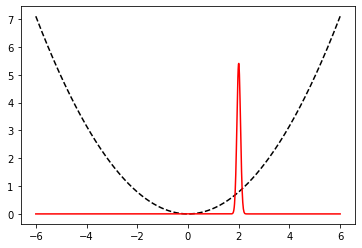

In [11]:
# wave packet
plt.plot(x, V.detach()*0.01, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")
plt.plot(x, np.abs(psi_wp)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.show()

In [13]:
# evolution
#u = 1j * 4*m* dx**2 / ( hbar * dt )
#beta = 2*m* dx**2 / hbar**2

# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

D2.toarray()*dx**2

D2t = torch.as_tensor(D2.toarray(), dtype = torch.float32)


# Matrix of kinetic energy
T_matrix = - (hbar**2 / (2*m)) * D2t

In [14]:
T_matrix

tensor([[ 6958.3403, -3479.1702,    -0.0000,  ...,    -0.0000,    -0.0000,
            -0.0000],
        [-3479.1702,  6958.3403, -3479.1702,  ...,    -0.0000,    -0.0000,
            -0.0000],
        [   -0.0000, -3479.1702,  6958.3403,  ...,    -0.0000,    -0.0000,
            -0.0000],
        ...,
        [   -0.0000,    -0.0000,    -0.0000,  ...,  6958.3403, -3479.1702,
            -0.0000],
        [   -0.0000,    -0.0000,    -0.0000,  ..., -3479.1702,  6958.3403,
         -3479.1702],
        [   -0.0000,    -0.0000,    -0.0000,  ...,    -0.0000, -3479.1702,
          6958.3403]])

In [72]:
# example of a matrix product
torch.einsum('ij,j->i', D2t, psi_wp)#.sum()

tensor([0., 0., 0.,  ..., 0., 0., 0.])

### construction of hamiltonian

In [15]:
H = T_matrix + V_matrix
H

tensor([[ 7668.9517, -3479.1702,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [-3479.1702,  7666.1123, -3479.1702,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, -3479.1702,  7663.2783,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0000,     0.0000,     0.0000,  ...,  7663.2783, -3479.1702,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ..., -3479.1702,  7666.1123,
         -3479.1702],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000, -3479.1702,
          7668.9517]], grad_fn=<AddBackward0>)

In [16]:
%%timeit
# eigenvalues for hermitian matrix
torch.linalg.eigh(H)

61 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
eigenvalues, eigenvectors = torch.linalg.eigh(H)

In [18]:
eigenvalues

tensor([3.1446e+00, 9.4332e+00, 1.5721e+01,  ..., 1.4509e+04, 1.4560e+04,
        1.4560e+04], grad_fn=<LinalgEighBackward0>)

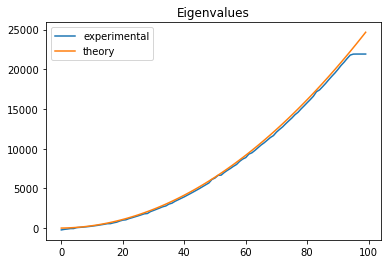

In [115]:
theorical_eigvals = [hbar**2 * np.pi**2/(2*m*2)*n**2   for n in range(1,N)]

limit = 100
plt.plot(eigenvalues.detach()[:limit], label='experimental')
plt.plot(theorical_eigvals[:limit], label='theory')
plt.legend()
plt.title('Eigenvalues')
plt.show()

In [116]:
theorical_eigvals

[2.4674011002723395,
 9.869604401089358,
 22.206609902451056,
 39.47841760435743,
 61.68502750680849,
 88.82643960980423,
 120.90265391334464,
 157.91367041742973,
 199.8594891220595,
 246.74011002723395,
 298.5555331329531,
 355.3057584392169,
 416.99078594602537,
 483.61061565337855,
 555.1652475612764,
 631.6546816697189,
 713.0789179787062,
 799.437956488238,
 890.7317971983146,
 986.9604401089358,
 1088.1238852201018,
 1194.2221325318123,
 1305.2551820440676,
 1421.2230337568676,
 1542.125687670212,
 1667.9631437841015,
 1798.7354020985356,
 1934.4424626135142,
 2075.0843253290377,
 2220.6609902451055,
 2371.1724573617184,
 2526.6187266788756,
 2686.9997981965776,
 2852.3156719148246,
 3022.566347833616,
 3197.751825952952,
 3377.8721062728328,
 3562.927188793258,
 3752.9170735142284,
 3947.8417604357433,
 4147.701249557803,
 4352.495540880407,
 4562.224634403556,
 4776.888530127249,
 4996.487228051487,
 5221.0207281762705,
 5450.489030501598,
 5684.89213502747,
 5924.230041753887

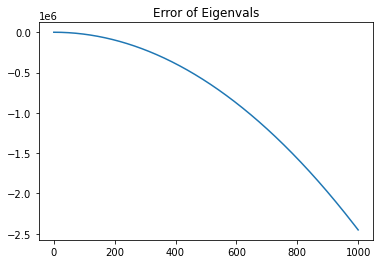

In [29]:
plt.plot(eigenvalues.detach().numpy()- theorical_eigvals)
plt.title('Error of Eigenvals')
plt.show()

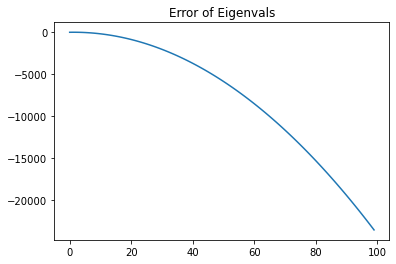

In [30]:
plt.plot(eigenvalues.detach().numpy()[:limit]- theorical_eigvals[:limit])
plt.title('Error of Eigenvals')
plt.show()

In [35]:
# compute the error in tensor world
#theorical_eigvals = [hbar*omega*(i + 1/2) for i in range(N)]
target = torch.tensor(theorical_eigvals)

error = eigenvalues - target
error

tensor([ 3.1446e+00,  6.9658e+00,  5.8516e+00,  ..., -2.4430e+06,
        -2.4479e+06, -2.4528e+06], grad_fn=<SubBackward0>)

In [37]:
limit = 100

L2loss = torch.nn.MSELoss()
loss = L2loss(eigenvalues[:limit], target[:limit])

In [38]:
loss.backward()

In [40]:
V.grad

tensor([-6.4826e-05, -2.6633e-04, -6.2567e-04,  ..., -6.2569e-04,
        -2.6634e-04, -6.4829e-05])

In [44]:
V = V - *V.grad

C:\Users\fbien.DESKTOP-6FMEAR7\AppData\Local\Temp\ipykernel_13004\179885609.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  V = V - 10*V.grad


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [46]:
V

tensor([710.6116, 707.7722, 704.9385,  ..., 704.9385, 707.7722, 710.6116],
       grad_fn=<SubBackward0>)

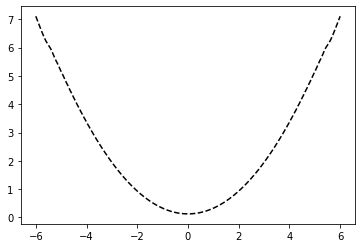

In [45]:
# wave packet
plt.plot(x, V.detach()*0.01, "k--", label=r"evolution")
#plt.plot(x, np.abs(psi_wp)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.show()

In [47]:
V_matrix

tensor([[710.6115,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000, 707.7719,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000, 704.9379,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ..., 704.9379,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000, 707.7719,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 710.6115]],
       grad_fn=<DiagEmbedBackward0>)

In [125]:
A = 2
alpha = 3

target = torch.tensor([A**2 - (A-n*alpha)**2 for n in range(1,100)], dtype=torch.float32)


In [140]:
loss_array = []

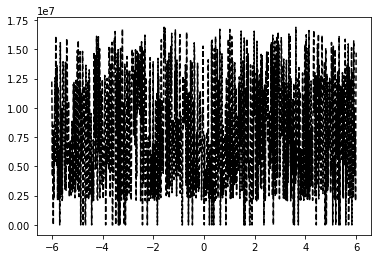

In [160]:
epoch = 300
lr = 0.05
while(epoch > 0):
    V_matrix = torch.diag(V)
    V_matrix
    H = T_matrix + V_matrix
    H
    eigenvalues, eigenvectors = torch.linalg.eigh(H)
    limit = 50
    loss = L2loss(eigenvalues[:limit], target[:limit])
    loss_array.append(loss.item())
    V.retain_grad()
    loss.backward()
    V = V - lr * V.grad
    epoch -=1

# wave packet
plt.plot(x, V.detach()*0.01, "k--", label=r"evolution")
#plt.plot(x, np.abs(psi_wp)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.show()

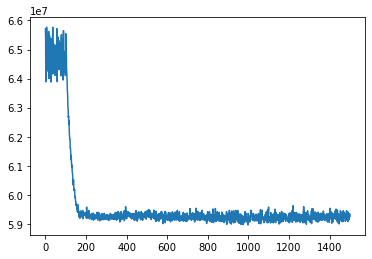

In [161]:
plt.plot(loss_array[300:])

In [139]:
loss.item()

6612402044928.0

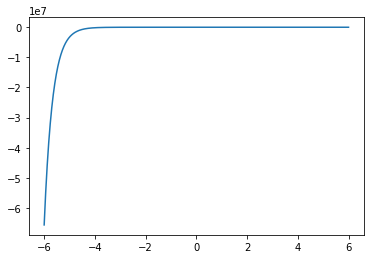

In [133]:
B = 1
x
Vtarget = A - B * np.exp(- alpha*x)

plt.plot(x, Vtarget)